In [1]:
# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
np.set_printoptions(suppress=True)

import bayesflow as beef
import tensorflow as tf

import sys
sys.path.append("../")
from experiment import ModelComparisonExperiment

/home/divergence/anaconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
experiment = ModelComparisonExperiment()

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ../checkpoints/model_comparison/history_51.pkl.
INFO:root:Networks loaded from ../checkpoints/model_comparison/ckpt-51


# Training

In [4]:
with open('../data/training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)
with open('../data/validation_data.pkl', 'rb') as f:
    validation_data = pickle.load(f)

In [9]:
validation_data['model_outputs'][0]['sim_data'].shape

(200, 800, 1)

In [5]:
history = experiment.run(
    training_data=training_data,
    validation_data=validation_data
    )

Training epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

ResourceExhaustedError: Exception encountered when calling layer 'multi_head_attention' (type MultiHeadAttention).

{{function_node __wrapped__Einsum_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[800,4,800,800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Einsum]

Call arguments received by layer 'multi_head_attention' (type MultiHeadAttention):
  • query=tf.Tensor(shape=(800, 800, 1), dtype=float32)
  • value=tf.Tensor(shape=(800, 800, 1), dtype=float32)
  • key=tf.Tensor(shape=(800, 800, 1), dtype=float32)
  • attention_mask=None
  • return_attention_scores=False
  • training=None
  • use_causal_mask=False

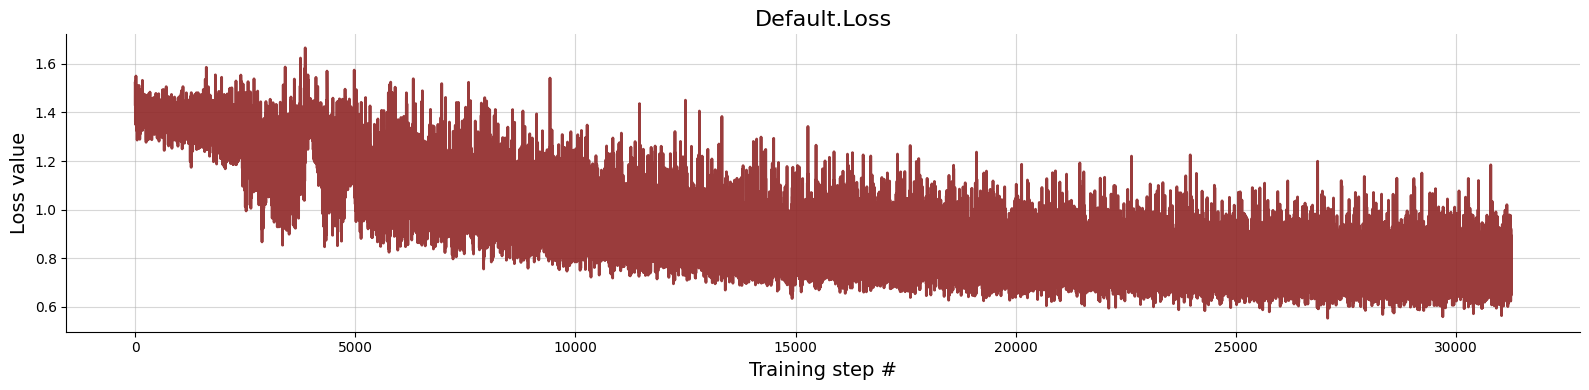

In [14]:
f = beef.diagnostics.plot_losses(history)

In [23]:
configurator = beef.configuration.DefaultModelComparisonConfigurator(4)
validation_data_configured = configurator(validation_data)

In [24]:
with tf.device('/cpu:0'):
    out = experiment.amortizer.posterior_probs(validation_data_configured)

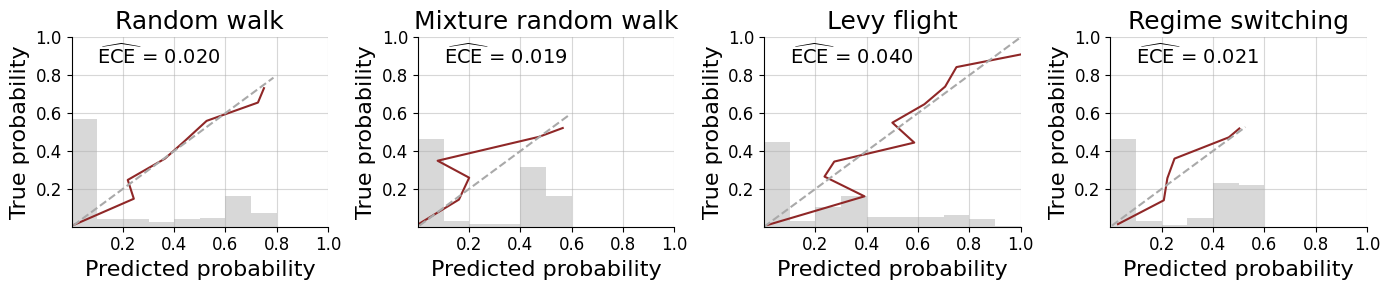

In [28]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=validation_data_configured['model_indices'],
    pred_models=out,
    model_names=['Random walk',
                 'Mixture random walk',
                 'Levy flight',
                 'Regime switching'],
    fig_size=(14, 3)
)

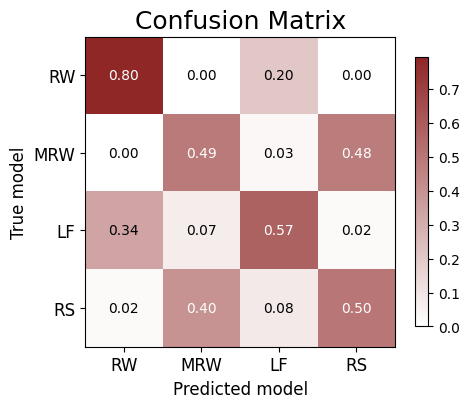

In [27]:
confusion_matrix = beef.diagnostics.plot_confusion_matrix(
    validation_data_configured['model_indices'],
    out,
    model_names=['RW', 'MRW', 'LF', 'RS']
)